In [1]:
from dlc_practical_prologue import generate_pair_sets

nSamples = 1000
data = generate_pair_sets(nSamples)
var_names = ["train_input", "train_target", "train_classes", "test_input", "test_target", "test_classes"]
train_input, train_target, train_classes, test_input, test_target, test_classes = data
stringWidth = 20
for i, el in enumerate(list(map(lambda x: (x.shape, x.dtype), data))):
    print('{:s}  {:s}  {:s}'.format(
        var_names[i].ljust(stringWidth),
        ' x '.join(list(map(lambda x: str(x), list(el[0])))).center(stringWidth), 
        'dtype'.ljust(stringWidth)))

train_input            1000 x 2 x 14 x 14   dtype               
train_target                  1000          dtype               
train_classes               1000 x 2        dtype               
test_input             1000 x 2 x 14 x 14   dtype               
test_target                   1000          dtype               
test_classes                1000 x 2        dtype               


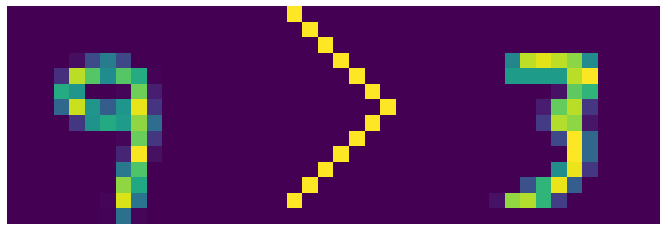

In [2]:
from utils import show_pair

show_pair(train_input, train_target, 0)

## Without using the information from the classes

In [55]:
import torch.nn as nn
from torch.nn import functional as F
import torch

class Net(nn.Module):
    def __init__(self, h1, h2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(64, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(2*h2, 1)
        self.drop = nn.Dropout(p=0.3)
        
    def element_forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(-1, 64)))
        x = self.drop(x)
        x = self.fc2(x)
        
        return x 

    def forward(self, x):
        x1 = x[:, 0, :, :].unsqueeze(axis = 1)
        x2 = x[:, 1, :, :].unsqueeze(axis = 1)
        
    
        x1 = self.element_forward(x1)
        x2 = self.element_forward(x2)
        
        # I'd like to do (x1 <= x2).float().squeeze(), but then loss.backward() doesn't work
        x = torch.cat([x1, x2], axis = 1)
        x = self.fc3(x).squeeze()
        
        
        return x
    
def accuracy(model, input_, target, mini_batch_size):
    nb_errors = 0
    for i in range(0, input_.size(0), mini_batch_size):
        output = model(input_.narrow(0, i, mini_batch_size))
        if output.isnan().sum():
            print('NANS')
            
        pred = (output > 0).long()
        gt = target.narrow(0, i, mini_batch_size)
        nb_errors += (pred != gt).sum().item()
    N = input_.shape[0]
    return 100*(N-nb_errors)/N



def train_model(model, train_input, train_target, mini_batch_size, optimizer, verbose = True):
    for e in range(nb_epochs):
        epoch_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            input_ = train_input.narrow(0, b, mini_batch_size)
            output = model(input_)
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            epoch_loss += loss.item()

            model.zero_grad()
            
            loss.backward()
            optimizer.step()
                    
        train_acc = accuracy(model, train_input, train_target, mini_batch_size)
        test_acc = accuracy(model, test_input, test_target, mini_batch_size)
        
        if verbose:
            print('Epoch {:d}: loss {:.3f} / train accuracy {:.1f}%, test accuracy {:.1f}'.format(
                e, epoch_loss, train_acc, test_acc))

In [59]:
model = Net(200, 10)
criterion = nn.BCEWithLogitsLoss()
eta = 1e-3
mini_batch_size = 10
optimizer = torch.optim.Adam(model.parameters(), lr = eta)
nb_epochs = 10


        
train_model(model, train_input, train_target.float(), mini_batch_size, optimizer)

Epoch 0: loss 54.451 / train accuracy 81.4%, test accuracy 80.5
Epoch 1: loss 36.914 / train accuracy 85.5%, test accuracy 81.2
Epoch 2: loss 34.554 / train accuracy 83.5%, test accuracy 81.1
Epoch 3: loss 31.035 / train accuracy 89.6%, test accuracy 84.4
Epoch 4: loss 23.547 / train accuracy 87.7%, test accuracy 82.6
Epoch 5: loss 21.905 / train accuracy 95.2%, test accuracy 82.8
Epoch 6: loss 17.663 / train accuracy 95.7%, test accuracy 84.8
Epoch 7: loss 14.333 / train accuracy 94.0%, test accuracy 83.8
Epoch 8: loss 12.804 / train accuracy 96.2%, test accuracy 83.0
Epoch 9: loss 9.355 / train accuracy 97.1%, test accuracy 84.2


In [61]:
nParams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('The model has {:d} trainable parameters'.format(nParams))

The model has 32855 trainable parameters


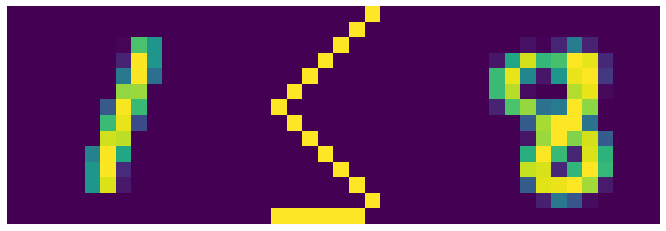

In [62]:
predictions = model(test_input)
show_pair(test_input, predictions, 10)